##### Use Run All option in Jupyter Notebook

##### The `x_training_scaled` values can be alternated between 300 and 900 nautical miles

In [1]:
# Uncomment the following lines to install the required packages

# pip install dymos
# pip install -U matplotlib
# conda install -c conda-forge pyoptsparse
# pip install pandas
# pip install bokeh

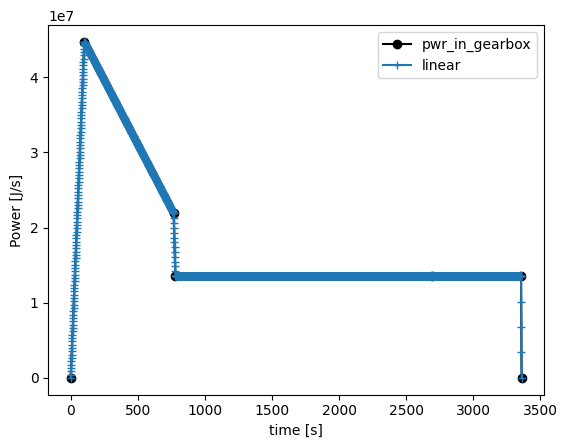

In [2]:
import numpy as np
from openmdao.components.interp_util.interp import InterpND

import matplotlib.pyplot as plt

pwr_in_gearbox = np.array([0.0, 44693976.3, 21876560.9, 13546016.7, 13546016.7, 13546016.7, 0.0])

# 300 NM
x_training_scaled = np.array([0, 101, 767, 780, 2690, 3356, 3360])
# 900 NM
# x_training_scaled = np.array([0, 101, 767, 780, 6534, 7201, 7260])


# Training interp with time (in [s]) and power (in [J/s])
interp_linear = InterpND(method='slinear', points=x_training_scaled, values=pwr_in_gearbox)

# Creating range for time corresponding to power in J/s
x_range = np.linspace(0.0, x_training_scaled[-1], x_training_scaled[-1] + 1)
# x_range should be all in 1 [s] like 0, 1, 2, 3, 4, ...
# print(x_range)

y_range_linear = interp_linear.interpolate(x_range)

plt.plot(x_training_scaled, pwr_in_gearbox, marker = 'o', color='black', label='pwr_in_gearbox')
plt.plot(x_range, y_range_linear, marker = '+', label='linear')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Power [J/s]')
plt.show()
np.set_printoptions(threshold=100000)

In [3]:
np.savetxt("power-values.csv", y_range_linear, delimiter=",", fmt='%.4f')
np.savetxt("time-points.csv", x_range, delimiter=",", fmt='%.4f')

In [ ]:
import openmdao.api as om
import dymos as dm
import matplotlib.pyplot as plt
import numpy as np

from FCBatSysODE import FCBatSysODEGroup

def kWh_to_J(kWh):
    return kWh * 1000 * 3600

pwr_in_gearbox = np.loadtxt("power-values.csv", delimiter=",", dtype=float)
time_points = np.loadtxt("time-points.csv", delimiter=",", dtype=float)

# Decide the number of segments (as an integer) of the problem based on total time steps
num_segments = np.round(pwr_in_gearbox.size/(3*1000)) * 100 # Replace 2 with 4 for 900 NM
num_segments = num_segments.astype(int)
num_segments_np = np.int64(num_segments)
num_segments = int(num_segments_np)
print(num_segments)

# Define the OpenMDAO problem and the problem has a model group within it.
prob = om.Problem(model=om.Group())

# Add a transcription to the problem
transcription0 = dm.GaussLobatto(num_segments=num_segments, order=3, compressed=True)

# Add a trajectory to the problem
traj = dm.Trajectory()
prob.model.add_subsystem('traj', traj)

# Define a Dymos Phase object with GaussLobatto Transcription
phase = dm.Phase(ode_class=FCBatSysODEGroup, transcription=transcription0)

# Add a phase to the trajectory
traj.add_phase(name='phase0', phase=phase)

# Set the time options and project the time onto the phase
phase.set_time_options(fix_initial=True, fix_duration=True, time_phase_targets=['time_phase'])

### States ###
phase.add_state('SoC', opt=True, fix_initial=True, fix_final=False, final_bounds=(0.3, 0.8), units=None, rate_source='dXdt:SoC', defect_scaler=1e-10)
# Gauss-lobatto required path constrain
phase.add_path_constraint('SoC', lower=0.3, upper=0.8)

phase.add_state('mass_fuel', opt=True, fix_initial=False, initial_bounds=(5, 10000), fix_final=True, units=None, rate_source='dXdt:mass_fuel', scaler=1e-4, defect_scaler=1e-15)
# Gauss-lobatto required path constrain
phase.add_path_constraint('mass_fuel', lower=0.0, upper=10000.0, scaler=1e-4)

### Dynamic Controls ###
phase.add_control(name='nminus1_active_fcsysmodules', targets=['nminus1_active_fcsysmodules'], opt=True, lower=0, upper=np.round(max(pwr_in_gearbox)/110000), continuity=False, rate_continuity=False, rate2_continuity=False, scaler=1e-3)

phase.add_control(name='current_nminus1fcstack', targets=['current_nminus1fcstack'], opt=True, lower=50, upper=642, continuity=False, rate_continuity=False, rate2_continuity=False, scaler=1e-3)

phase.add_control(name='current_nthfcstack', targets=['current_nthfcstack'], opt=True, lower=0, upper=642, continuity=False, rate_continuity=False, rate2_continuity=False, scaler=1e-3)

phase.add_control(name='C_rate', targets=['C_rate'], opt=True, lower=-1.0, upper=2.5, continuity=False, rate_continuity=False, rate2_continuity=False, scaler=1e-1, adder=1)

### Static Controls ###
split_ratio_default = 0.5
phase.add_parameter('split_ratio', targets=['split_ratio'], opt=True, val=split_ratio_default, lower=0, upper=1, static_target=False)

egy_batsys_default = 1000 # kWh
phase.add_parameter('egy_batsys', targets=['egy_batsys'], opt=True, val=kWh_to_J(egy_batsys_default), lower=kWh_to_J(0.001), upper=kWh_to_J(5000*4*5), static_target=False, scaler=1e-10)

### Fixed Static Controls ###
current_maxfcstack_default = 642.0 #A
phase.add_parameter('current_maxfcstack', targets=['current_maxfcstack'], opt=False, val=current_maxfcstack_default, static_target=False)

### Static Controls to be set by the user ###
grav_eff_h2_default = 0.15 #%
phase.add_parameter('grav_eff_h2', targets=['grav_eff_h2'], opt=False, val=grav_eff_h2_default, lower=0.01, upper=0.45, static_target=False)

pwr_dens_fcstack_default = 1 #kW/kg
phase.add_parameter('pwr_dens_fcstack', targets=['pwr_dens_fcstack'], opt=False, val=pwr_dens_fcstack_default, lower=0.01, upper=4, static_target=False)

egy_dens_batsys_default = 0.25 # kWh/kg
phase.add_parameter('egy_dens_batsys', targets=['egy_dens_batsys'], opt=False, val=egy_dens_batsys_default, lower=0.25, upper=2.5, static_target=False)

prob.model.linear_solver =  om.DirectSolver()

# Add Objective
phase.add_objective('tot_takeoff_mass', loc='initial', scaler=1e-5)

# Add a driver
prob.driver = driver =  om.pyOptSparseDriver()
prob.driver.options['optimizer'] = 'IPOPT'
prob.driver.opt_settings['mu_strategy'] = 'adaptive'
prob.driver.opt_settings['bound_mult_init_method'] = 'mu-based'
prob.driver.opt_settings['mu_init'] = 0.01 # 1e-1
prob.driver.opt_settings['nlp_scaling_method'] = 'gradient-based'

# Add a driver case recorder to monitor all values of all variables over all time steps and function evaluations.
driver.recording_options['includes'] = ['*']
driver.recording_options['record_objectives'] = True
driver.recording_options['record_constraints'] = True
driver.recording_options['record_desvars'] = True
driver.recording_options['record_inputs'] = True
driver.recording_options['record_outputs'] = True
driver.recording_options['record_residuals'] = True
driver.add_recorder(om.SqliteRecorder("driver_cases.sql"))

# Enable Sparsity Pattern detection
prob.driver.declare_coloring()

# Save all data to another output file which plots these variables
phase.add_timeseries_output('n_fcsysmodules', units=None, shape=(1,))
phase.add_timeseries_output('dXdt:mass_fuel', units=None, shape=(1,))
phase.add_timeseries_output('dXdt:SoC', units=None, shape=(1,))
phase.add_timeseries_output('con_fcbatsys_1', units=None, shape=(1,))
phase.add_timeseries_output('con_fcsys_2', units=None, shape=(1,))
phase.add_timeseries_output('con_fcsys_3', units=None, shape=(1,))
phase.add_timeseries_output('pwr_el_inout_batsys', units=None, shape=(1,))
phase.add_timeseries_output('pwr_el_del_per_maxfcsysmodule', units=None, shape=(1,))
phase.add_timeseries_output('pwr_el_del_fcsys', units=None, shape=(1,))
phase.add_timeseries_output('pwr_el_max_fcsys', units=None, shape=(1,))

# Setup the problem
prob.setup(check=True)

# //BUG: Enable PowerInterpolation Comp and Total mass take off Exec Comp.
# Setup time constraints
prob['traj.phase0.t_initial'] = 0.0
prob['traj.phase0.t_duration'] = time_points[-1]

# Initial values
prob['traj.phase0.states:mass_fuel'] = phase.interp('mass_fuel', [2500, 0])
prob['traj.phase0.states:SoC'] = phase.interp('SoC', [0.8, 0.3])

prob['traj.phase0.controls:nminus1_active_fcsysmodules'][:] = 200
prob['traj.phase0.controls:current_nminus1fcstack'][:] = 321
prob['traj.phase0.controls:current_nthfcstack'][:] = 321
prob['traj.phase0.controls:C_rate'][:] = 0.5


prob.set_solver_print(level=0)

# prob.model.list_inputs(units=True, shape=True)
# prob.model.list_outputs(units=True, shape=True)

dm.run_problem(prob, run_driver=True, simulate=True, make_plots=True)

300


/Users/h1he2li3/anaconda3/envs/OM-dymos4/lib/python3.12/site-packages/dymos/phase/phase.py:2059: RuntimeWarning: Invalid options for non-optimal parameter 'grav_eff_h2' in phase 'phase0': lower, upper
  warnings.warn(f"Invalid options for non-optimal parameter '{name}' in "
/Users/h1he2li3/anaconda3/envs/OM-dymos4/lib/python3.12/site-packages/dymos/phase/phase.py:2059: RuntimeWarning: Invalid options for non-optimal parameter 'pwr_dens_fcstack' in phase 'phase0': lower, upper
  warnings.warn(f"Invalid options for non-optimal parameter '{name}' in "
/Users/h1he2li3/anaconda3/envs/OM-dymos4/lib/python3.12/site-packages/dymos/phase/phase.py:2059: RuntimeWarning: Invalid options for non-optimal parameter 'egy_dens_batsys' in phase 'phase0': lower, upper
  warnings.warn(f"Invalid options for non-optimal parameter '{name}' in "
/Users/h1he2li3/anaconda3/envs/OM-dymos4/lib/python3.12/site-packages/openmdao/core/group.py:2820: UnitsWarning:'traj.phases.phase0' <class Phase>: Output 'traj.phase


--- Constraint Report [traj] ---
    --- phase0 ---
        [path]    3.0000e-01 <= SoC <= 8.0000e-01  [None]
        [path]    0.0000e+00 <= mass_fuel <= 1.0000e+04  [None]

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


/Users/h1he2li3/anaconda3/envs/OM-dymos4/lib/python3.12/site-packages/openmdao/recorders/sqlite_recorder.py:226: UserWarning:The existing case recorder file, driver_cases.sql, is being overwritten.
/Users/h1he2li3/anaconda3/envs/OM-dymos4/lib/python3.12/site-packages/openmdao/recorders/sqlite_recorder.py:226: UserWarning:The existing case recorder file, dymos_solution.db, is being overwritten.


Model viewer data has already been recorded for Driver.
Model viewer data has already been recorded for Driver.
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Model viewer data has already been recorded for Driver.
Model viewer data has already been recorded for Driver.
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Full total jacobian for problem 'problem' was computed 3 times, taking 88.4927621249808 seconds.
Total jacobian shape: (5101, 3006) 


Jacobian shape: (5101, 3006)  (0.58% nonzero)
FWD solves: 29   REV solves: 0
Total colors vs. total size: 29 vs 3006  (99.04% improvement)

Sparsity computed using t

/Users/h1he2li3/anaconda3/envs/OM-dymos4/lib/python3.12/site-packages/openmdao/core/total_jac.py:1635: DerivativesWarning:Constraints or objectives [('traj.phases.phase0->path_constraint->SoC', inds=[(0, 0)]), ('traj.phases.phase0->path_constraint->mass_fuel', inds=[(899, 0)])] cannot be impacted by the design variables of the problem.




Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                   80.5250
       User Objective Time :       4.2073
       User Sensitivity Time :    74.5701
       Interface Time :            1.2376
       Opt Solver Time:            0.5100
    Calls to Objective Function :      28
    Calls to Sens Function :           28


   Objectives
      Index  Name                                             Value
          0  traj.phase0.rhs_disc.tot_takeoff_mass     7.786097E-01

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name                                                   Type      Lower Bound            Value      Upper Bound     Status
          0  traj.phase0.parameters:split_ratio_0                      c     0.000000E+00     8.010602E-01     1.000000E+00           
          1  traj.phase0.parameters:eg

/Users/h1he2li3/anaconda3/envs/OM-dymos4/lib/python3.12/site-packages/dymos/phase/phase.py:2059: RuntimeWarning: Invalid options for non-optimal parameter 'grav_eff_h2' in phase 'phase0': lower, upper
  warnings.warn(f"Invalid options for non-optimal parameter '{name}' in "
/Users/h1he2li3/anaconda3/envs/OM-dymos4/lib/python3.12/site-packages/dymos/phase/phase.py:2059: RuntimeWarning: Invalid options for non-optimal parameter 'pwr_dens_fcstack' in phase 'phase0': lower, upper
  warnings.warn(f"Invalid options for non-optimal parameter '{name}' in "
/Users/h1he2li3/anaconda3/envs/OM-dymos4/lib/python3.12/site-packages/dymos/phase/phase.py:2059: RuntimeWarning: Invalid options for non-optimal parameter 'egy_dens_batsys' in phase 'phase0': lower, upper
  warnings.warn(f"Invalid options for non-optimal parameter '{name}' in "
/Users/h1he2li3/anaconda3/envs/OM-dymos4/lib/python3.12/site-packages/openmdao/recorders/sqlite_recorder.py:226: UserWarning:The existing case recorder file, dymos_si


Simulating trajectory traj
Model viewer data has already been recorded for Driver.
Done simulating trajectory traj


False

In [5]:
import sqlite3
import pandas as pd

# Load the SQLite database
db_path = './driver_cases.sql'
conn = sqlite3.connect(db_path)

# List all tables in the SQLite database
try:
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    tables = pd.read_sql_query(query, conn)
    print("Tables in the database:")
    print(tables)
except Exception as e:
    print(f"An error occurred while listing tables: {e}")
finally:
    conn.close()

print('------------------')


import sqlite3
import pandas as pd

# Load the SQLite database
db_path = './driver_cases.sql'
conn = sqlite3.connect(db_path)

# Extract a small sample of data from the driver_iterations table
try:
    query = "SELECT * FROM driver_iterations LIMIT 5;"
    sample_data = pd.read_sql_query(query, conn)
    print("Sample data from 'driver_iterations' table:")
    print(sample_data)
except Exception as e:
    print(f"An error occurred while extracting sample data: {e}")
finally:
    conn.close()

Tables in the database:
                 name
0   global_iterations
1   driver_iterations
2  driver_derivatives
3       problem_cases
4   system_iterations
5   solver_iterations
6            metadata
7     driver_metadata
8     system_metadata
9     solver_metadata
------------------
Sample data from 'driver_iterations' table:
   id  counter       iteration_coordinate      timestamp  success msg  \
0   1        1  rank0:pyOptSparse_IPOPT|0  393424.708718        1       
1   2        2  rank0:pyOptSparse_IPOPT|1  393477.780679        1       
2   3        3  rank0:pyOptSparse_IPOPT|2  393478.797212        1       
3   4        4  rank0:pyOptSparse_IPOPT|3  393479.775354        1       
4   5        5  rank0:pyOptSparse_IPOPT|4  393480.867510        1       

                                              inputs  \
0  {"traj.phases.phase0.collocation_constraint.dt...   
1  {"traj.phases.phase0.collocation_constraint.dt...   
2  {"traj.phases.phase0.collocation_constraint.dt...   
3  {"tra

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


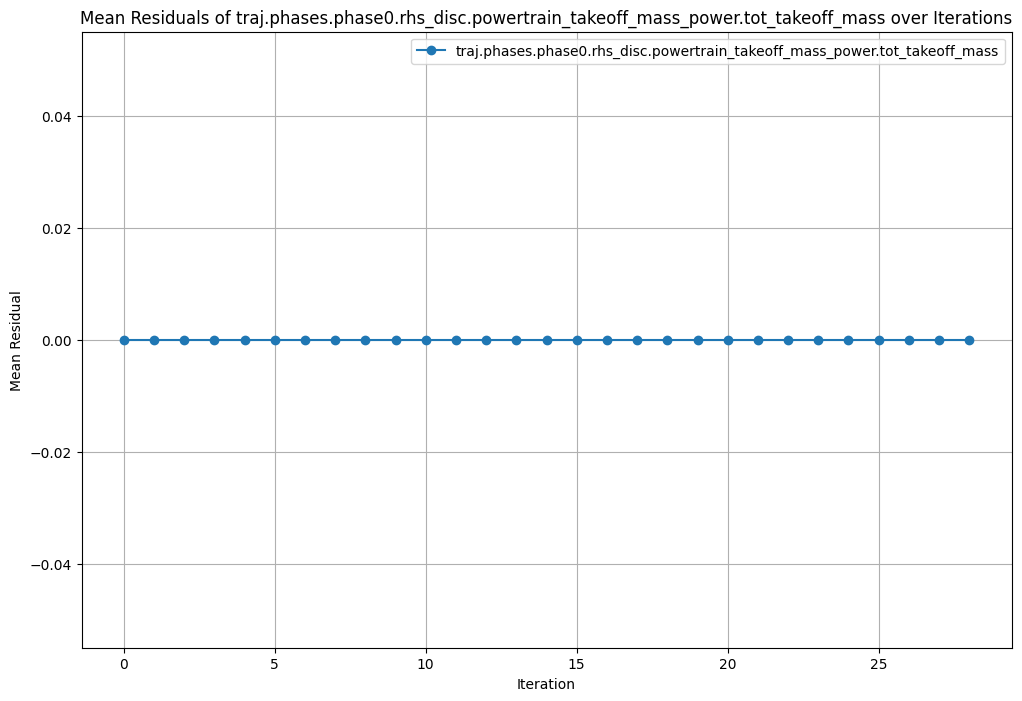

In [6]:
import sqlite3
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load the SQLite database
db_path = './driver_cases.sql'
conn = sqlite3.connect(db_path)

# Load data from the driver_iterations table
try:
    query = "SELECT * FROM driver_iterations;"
    driver_iterations_data = pd.read_sql_query(query, conn)

    # Extract residuals
    def extract_residuals(residuals_str):
        try:
            return json.loads(residuals_str)
        except json.JSONDecodeError:
            return None

    driver_iterations_data['residuals'] = driver_iterations_data['residuals'].apply(extract_residuals)

    # Drop rows where residuals is None
    residuals_data = driver_iterations_data.dropna(subset=['residuals'])

    # Extract and plot a specific residual
    selected_residual_key = 'traj.phases.phase0.rhs_disc.powertrain_takeoff_mass_power.tot_takeoff_mass'

    # Create a dataframe to store mean residuals per iteration
    mean_residuals_per_iteration = []

    for i, row in residuals_data.iterrows():
        residuals_dict = row['residuals']
        if selected_residual_key in residuals_dict:
            residual_values = residuals_dict[selected_residual_key]
            mean_residual = sum(residual_values) / len(residual_values)
            mean_residuals_per_iteration.append((i, mean_residual))

    # Convert to DataFrame for easier plotting
    mean_residuals_df = pd.DataFrame(mean_residuals_per_iteration, columns=['Iteration', 'Mean Residual'])

    # Plot mean residuals
    plt.figure(figsize=(12, 8))
    plt.plot(mean_residuals_df['Iteration'], mean_residuals_df['Mean Residual'], marker='o', label=selected_residual_key)

    plt.xlabel('Iteration')
    plt.ylabel('Mean Residual')
    plt.title(f'Mean Residuals of {selected_residual_key} over Iterations')
    plt.legend()
    plt.grid(True)
    plt.savefig('dymos_driver_mass_residual.eps', format='eps', dpi=600)
    plt.savefig('dymos_driver_mass_residual.pdf', format='pdf', dpi=600)
    plt.show()


except Exception as e:
    print(f"An error occurred while extracting and plotting residuals: {e}")
finally:
    conn.close()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


55912.241218528536
55912.241218528536
59865.78223591675
64531.22112308933
74979.14027069727
81668.35677149075
81006.07248566509
78308.7630128093
78361.30403809348
78356.90346573273
78426.41559783409
78415.66258376143
78396.79475682984
78367.61954885625
78303.58195614336
78297.67218930868
78293.90050191914
78175.8083240956
77910.83954797863
78011.40067783836
78018.34632093331
77940.53965262916
77923.61923675064
77874.1928439241
77868.62119634627
77865.98801346323
77863.39733920112
77860.97382062727
77860.97382062727


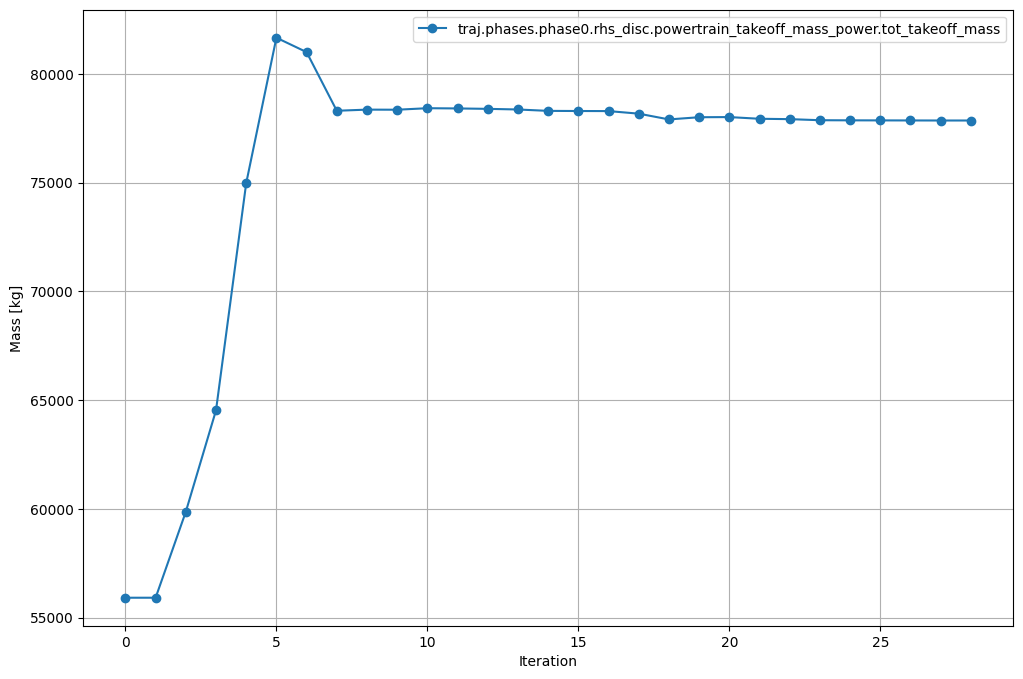

In [7]:
import sqlite3
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load the SQLite database
db_path = './driver_cases.sql'
conn = sqlite3.connect(db_path)

# Load data from the driver_iterations table
try:
    query = "SELECT * FROM driver_iterations;"
    driver_iterations_data = pd.read_sql_query(query, conn)

    # Extract outputs
    def extract_outputs(outputs_str):
        try:
            return json.loads(outputs_str)
        except json.JSONDecodeError:
            return None

    driver_iterations_data['outputs'] = driver_iterations_data['outputs'].apply(extract_outputs)

    # Drop rows where outputs is None
    outputs_data = driver_iterations_data.dropna(subset=['outputs'])

    # Extract and plot specific outputs
    selected_output_keys = [
        'traj.phases.phase0.rhs_disc.powertrain_takeoff_mass_power.tot_takeoff_mass',
        # 'traj.phases.phase0.rhs_col.powertrain_takeoff_mass_power.tot_takeoff_mass'
    ]

    plt.figure(figsize=(12, 8))

    for selected_output_key in selected_output_keys:
        values_per_iteration = []

        for i, row in outputs_data.iterrows():
            outputs_dict = row['outputs']
            if selected_output_key in outputs_dict:
                output_values = outputs_dict[selected_output_key]
                # mean_output = sum(output_values) / len(output_values) if isinstance(output_values, list) else output_values
                mean_output = output_values[0]
                print(mean_output)
                values_per_iteration.append((i, mean_output))

        # Convert to DataFrame for easier plotting
        values_df = pd.DataFrame(values_per_iteration, columns=['Iteration', 'Value'])

        # Plot values
        plt.plot(values_df['Iteration'], values_df['Value'], marker='o', label=selected_output_key)

    plt.xlabel('Iteration')
    plt.ylabel('Mass [kg]')
    # plt.title('Outputs over Iterations')
    plt.legend()
    plt.grid(True)
    plt.savefig('dymos_driver_mass.eps', format='eps', dpi=600)
    plt.savefig('dymos_driver_mass.pdf', format='pdf', dpi=600)
    plt.show()


except Exception as e:
    print(f"An error occurred while extracting and plotting outputs: {e}")
finally:
    conn.close()

In [8]:
import timeseries_plots

timeseries_plots.timeseries_plots('dymos_solution.db', simulation_record_file='dymos_simulation.db', plot_dir="plots")